# **Overview**

Sentiment analysis, a facet of Natural Language Processing, encompasses a range of methodologies designed to derive subjective insights from text or speech, including viewpoints and emotional tones. In essence, it revolves around categorizing text into positive, negative, or neutral sentiments.

Problem Statement:
The core aim of this endeavor is the identification and categorization of hate speech within tweets. To streamline the task, we define a tweet as being indicative of hate speech if it exhibits either racist or sexist sentiments. 

The main objective of this project is to detect instances of hate speech within tweets. To simplify the task, we consider a tweet to contain hate speech if it expresses either racist or sexist sentiments. 

To provide further details, this research is also be provided with a training dataset that includes tweets along with corresponding labels. Consequently, the task revolves around classifying tweets into three distinct categories:using the labels 'positive' will correspond to '1,' 'negative' to '-1,' and 'neutral' to '0'.

# Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing

# Load the abusive and normalization CSV files
abusive_dict = pd.read_csv('abusive.csv', encoding='latin-1')
normalization_dict = pd.read_csv('normalization.csv', encoding='latin-1')

#For Preprocessing
import re    # RegEx for removing non-letter characters
import pickle 
import nltk  #natural language processing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.porter import *

# For Building the model
import tensorflow as tf
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from keras.models import load_model
from keras.layers import Bidirectional
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from sklearn.preprocessing import LabelEncoder

# Doc2Vec Model
import gensim.downloader as api
from gensim import models

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
from sklearn import metrics
from collections import defaultdict
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline

pd.options.plotting.backend = "plotly"

c:\Users\USTER\anaconda3\envs\cc\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\USTER\anaconda3\envs\cc\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
c:\Users\USTER\anaconda3\envs\cc\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USTER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USTER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\Users\USTER\anaconda3\envs\cc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


# **Exploratory Data Analysis**

# Data Review

In [3]:
# Load dataset
df= pd.read_csv('train_preprocess.tsv', sep='\t', header=None)
# Output first five rows
df.columns =['text', 'label']
df.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [4]:
#Size of the data
df.shape

(11000, 2)

In [5]:
#Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11000 non-null  object
 1   label   11000 non-null  object
dtypes: object(2)
memory usage: 172.0+ KB


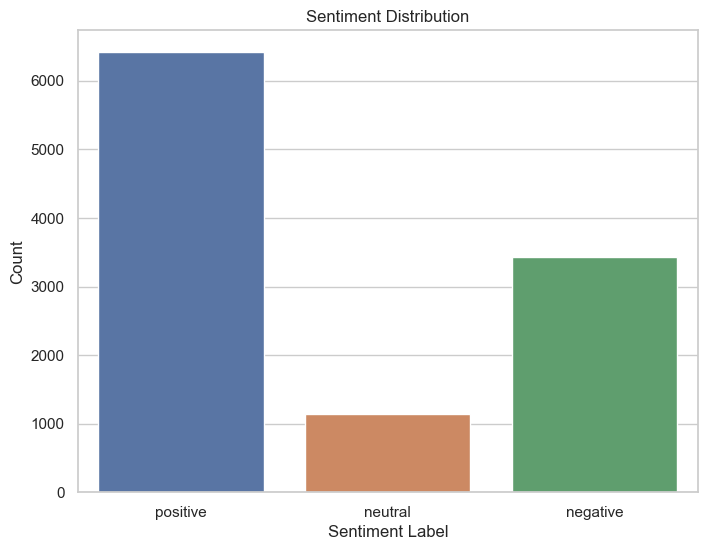

positive    6416
negative    3436
neutral     1148
Name: label, dtype: int64

In [6]:
# Visualize sentiment using a count plot
sns.set(style='whitegrid')
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

df.label.value_counts()

# **Text Normalization/Cleansing**

The textual content frequently comprises hyperlinked text, emoticons, and punctuation marks. To facilitate their utilization for educational purposes via a Language Model, the incorporation of such content into the model's training data is impermissible. Consequently, it becomes necessary to undertake the purification of the textual data through the employment of diverse preprocessing and cleansing methodologies.

In [7]:
# Data Cleansing
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

def remove_unnecessary_char(text):
    # Remove unnecessary characters
    text = re.sub(r"\n", "", text)
    # Remove every username
    text = re.sub(r"user", "", text)
    # Remove URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text)
    # Remove extra spaces
    text = re.sub('  +', ' ', text) 
    # Split a String
    text = re.sub(r"\s+", " ", text)
    # return list
    return text

# remove stopwords
# nltk.download('stopwords')
# stop = set(stopwords.words("indonesian"))
# def remove_stopwords(text):
#     filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
#     return " ".join(filtered_words)

# Transforming slang words "kata alay" into standard word
def normalize_alay(text):
    return ' '.join([normalization_dict[NORMALIZATION] if NORMALIZATION in normalization_dict else NORMALIZATION for NORMALIZATION in text.split(' ')])

def preprocess(text):
    text = remove_unnecessary_char(text) # 1
    text = remove_nonaplhanumeric(text) # 2
    # text = remove_stopwords(text) # 3
    text = normalize_alay(text) # 4
    return text

In [8]:
# Check the text normalization
print("\nOriginal tweet ->", df['text'][0])
print("\nProcessed tweet ->", preprocess(df['text'][0]))


Original tweet -> warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung . tahu berkualitas , dipadu keahlian memasak , dipadu kretivitas , jadilah warung yang menyajikan menu utama berbahan tahu , ditambah menu umum lain seperti ayam . semuanya selera indonesia . harga cukup terjangkau . jangan lewatkan tahu bletoka nya , tidak kalah dengan yang asli dari tegal !

Processed tweet -> warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung tahu berkualitas dipadu keahlian memasak dipadu kretivitas jadilah warung yang menyajikan menu utama berbahan tahu ditambah menu umum lain seperti ayam semuanya selera indonesia harga cukup terjangkau jangan lewatkan tahu bletoka nya tidak kalah dengan yang asli dari tegal 


In [9]:
#Text already clean
df['text_clean'] = df.text.apply(preprocess)
df.head()

,text,label,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k212 mmbri hujjah partai...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatera bandung tem...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh jadi mahasiswa jangan sombong dong kasih k...


# **Data Processing**

# *Categorization of Textual Data into 3 Sentiments and Data Preparation for Analysis.*
1. Sorting Sentences: This code organizes sentences based on whether they express positive, neutral, or negative feelings.
2. Counting Them: It then counts how many sentences are in each feeling group.
3. Combining Everything: All the sentences and their counts are put together in one place.
4. Preparing for Learning: Finally, the data is made ready for a computer to learn patterns from the sentences.

In [10]:
# Extract preprocessed text data based on "3 sentiment categories"
negative_texts = df.loc[df['label'] == 'negative'].text_clean.tolist()
neutral_texts = df.loc[df['label'] == 'neutral'].text_clean.tolist()
positive_texts = df.loc[df['label'] == 'positive'].text_clean.tolist()

# Extract labels corresponding to different sentiments
negative_labels = df.loc[df['label'] == 'negative'].label.tolist()
neutral_labels = df.loc[df['label'] == 'neutral'].label.tolist()
positive_labels = df.loc[df['label'] == 'positive'].label.tolist()

# Combine text data and labels for all sentiments
all_texts = positive_texts + neutral_texts + negative_texts
all_labels = positive_labels + neutral_labels + negative_labels

# Count examples for each sentiment category and determine total data size
num_positive = len(positive_texts)
num_neutral = len(neutral_texts)
num_negative = len(negative_texts)
total_data = len(all_texts)

# Display information about data distribution
print(f'Number of Examples with Positive Sentiment: {num_positive}')
print(f'Number of Examples with Neutral Sentiment: {num_neutral}')
print(f'Number of Examples with Negative Sentiment: {num_negative}')
print(f'Total Number of Data Examples: {total_data}')

Number of Examples with Positive Sentiment: 6416
Number of Examples with Neutral Sentiment: 1148
Number of Examples with Negative Sentiment: 3436
Total Number of Data Examples: 11000


# Feature Extraction

Tokenization is the process of breaking down a text into individual words or tokens. A tokenizer converts a text string into a sequence of words or subword units. 
 
 A Tokenizer is used to tokenize text data and create a vocabulary, where each unique word or subword is assigned an integer index. It's a basic step in preparing text data for various NLP tasks.

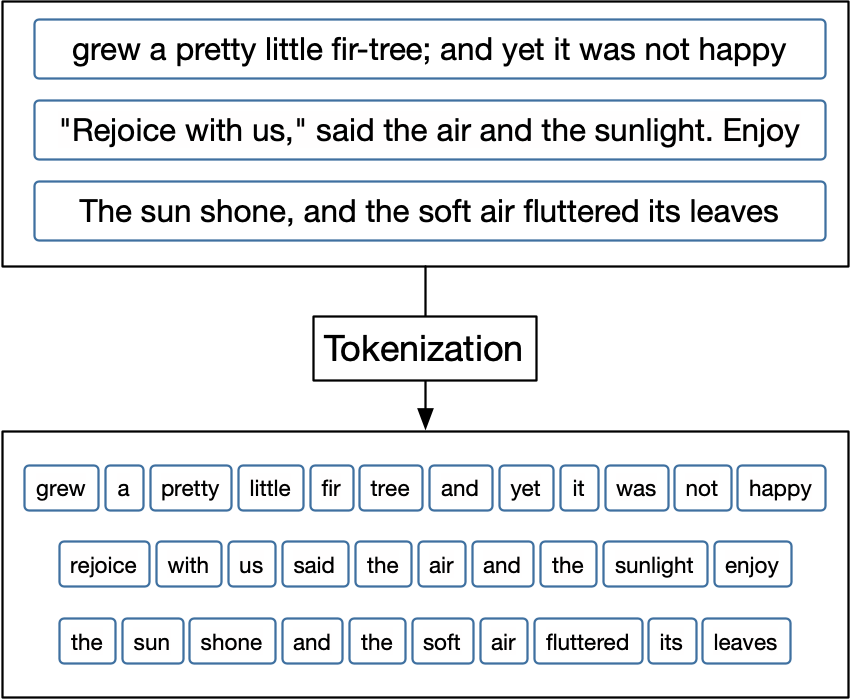

*Source: EmilHvitfeldt, Supervised Machine Learning for Text Analysis in R*

In [11]:
# Tokenization and Vocabulary Creation
max_features = 100000
tokenizer = Tokenizer(num_words=max_features, lower=True)
tokenizer.fit_on_texts(all_texts)
X = tokenizer.texts_to_sequences(all_texts)
X = pad_sequences(X)
vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

# Label Encoding
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(all_labels)
Y = to_categorical(Y, num_classes=3)  # Convert to one-hot encoded labels

By saving the label encoder, tokenizer, and processed data, it can create a snapshot of entire data preprocessing pipeline. This is particularly useful to deploy the model in a different environment or share it with others, ensuring that the preprocessing steps are consistent with what the model was trained on.

Remember to load these saved components when you want to evaluate your model on new data or deploy it for predictions. it can use the pickle module's load function to load the saved objects back into the code.

In [12]:
X = pad_sequences(X)
with open('x_pad_sequences.pickle','wb') as handle:
  pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('x_pad_sequences.pickle has created!')

Y = pd.get_dummies(all_labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
  pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('y_labels.pickle has created!')

x_pad_sequences.pickle has created!
y_labels.pickle has created!


In [13]:
#Split Dataset For Training & Testing
file = open('x_pad_sequences.pickle','rb')
X = pickle.load(file)
file.close()

file = open('y_labels.pickle','rb')
Y = pickle.load(file)
file.close()

# Split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=24)

# RNN Model

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 96, 100)           10000000  
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               29312     
                                                                 
 dense_6 (Dense)             (None, 3)                 387       
                                                                 
Total params: 10,029,699
Trainable params: 10,029,699
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
275/275 [==============================] - 21s 71ms/step - loss: 0.5842 - accuracy: 0.7570 - val_loss: 0.3918 - val_accuracy: 0.8455
Epoch 2/10
275/275 [==============================] - 19s 68ms/step - loss: 0.2378 - accuracy: 0.9100 - val_loss: 0.3968 - val_accuracy: 0.8541
Epoch 3/10
27

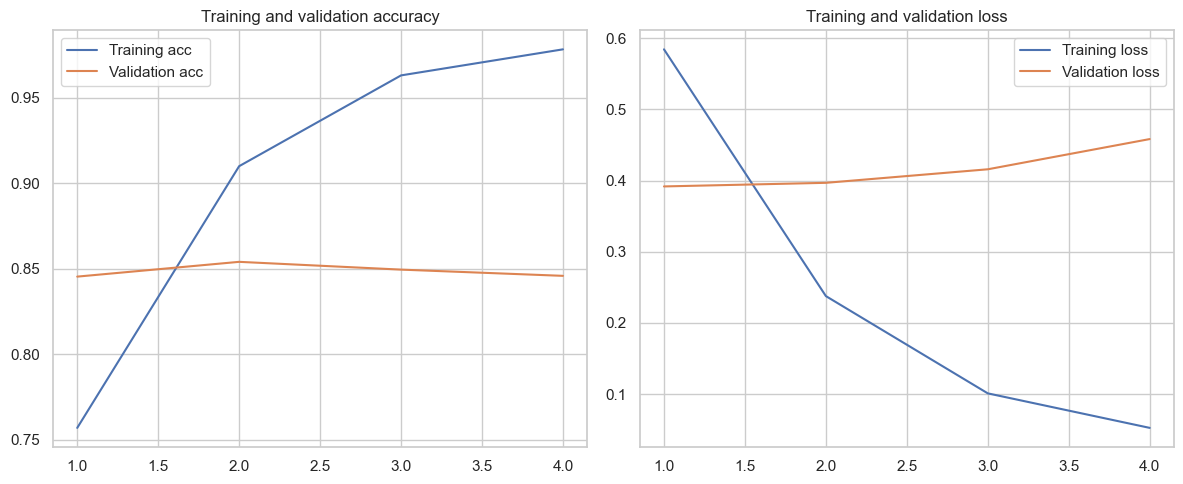

In [18]:
# Build the RNN model
n_classes = 3  # Number of sentiment classes
embed_dim = 100
units = 128
max_features = 100000
learning_rate = 0.001 

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Build the RNN model with a specified learning rate
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=maxlen))
model.add(SimpleRNN(units, dropout=0.2))  # Replace LSTM with SimpleRNN
model.add(Dense(n_classes, activation='softmax'))
# Create an Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
# Compile the model with the custom optimizer
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

# Fit model
batch_size = 32
history = model.fit(X_train, Y_train, epochs=10, verbose=1, batch_size=batch_size,
                    validation_data=(X_test, Y_test), callbacks=[early_stopping])  # Providing validation data

# Analyze the results
score, acc = model.evaluate(X_test, Y_test, verbose=2, batch_size=batch_size)
y_probs = model.predict(X_test)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test, verbose=2, batch_size=batch_size)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

# Function to plot training history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    
    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, label='Training acc')
    plt.plot(x, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, label='Training loss')
    plt.plot(x, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming history is the history object obtained from model.fit
plot_history(history)

Classification scores are used to evaluate how well a classification model is performing:
1. Precision: Accuracy of positive predictions.
2. Recall: Ability to capture positive instances.
3. F1-Score: Balance between precision and recall.
4. Specificity: Ability to capture negative instances.

In [19]:
# Define the label mapping (replace these with your actual class labels)
label_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

# Classification scores are used to evaluate how well a classification model is performing:
# 1. Get predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels

# 2. Convert one-hot encoded Y_test back to class labels
Y_test_classes = np.argmax(Y_test, axis=1)

# 3. Generate classification report
classification_rep = classification_report(Y_test_classes, y_pred_classes, target_names=label_mapping.values())
print("Classification Report:\n", classification_rep)


69/69 [==============================] - 1s 13ms/step
Classification Report:
               precision    recall  f1-score   support

    Negative       0.75      0.83      0.79       687
     Neutral       0.88      0.51      0.65       220
    Positive       0.90      0.91      0.90      1293

    accuracy                           0.85      2200
   macro avg       0.84      0.75      0.78      2200
weighted avg       0.85      0.85      0.84      2200



# *Cross-validation*

Cross-validation is a method in machine learning to assess and improve model performance. Rather than solely dividing data into training and testing portions, cross-validation divides it into multiple segments or folds. The model is trained on some folds and evaluated on others, cycling through all folds to obtain a comprehensive performance evaluation. This approach offers several benefits, including better performance estimation, reduced overfitting, efficient data utilization, hyperparameter tuning, understanding generalization capabilities, and identifying potential biases.

In [20]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

accuracies = []

for iteration, data in enumerate(kf.split(X), start=1):

    data_train = X[data[0]]
    target_train = Y[data[0]]  # Use Y represents the one-hot encoded labels

    data_test = X[data[1]]
    target_test = Y[data[1]]  # Use Y which represents the one-hot encoded labels

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(SimpleRNN(units=128, dropout=0.2))  # Changed from LSTM to SimpleRNN
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(data_train, target_train, epochs=10, batch_size=10, verbose=1)

    predictions = model.predict(data_test)
    y_pred = predictions.argmax(axis=1)

    accuracy = accuracy_score(target_test.argmax(axis=1), y_pred)

    print("Training round", iteration)
    print(classification_report(target_test.argmax(axis=1), y_pred))
    print("======================================================")

    accuracies.append(accuracy)

# Calculate the average accuracy over all folds
average_accuracy = np.mean(accuracies)
print()
print()
print()
print()
print("Average Accuracy: ", average_accuracy)

Epoch 1/10
880/880 [==============================] - 64s 71ms/step - loss: 0.8091 - accuracy: 0.6270
Epoch 2/10
880/880 [==============================] - 72s 82ms/step - loss: 0.3992 - accuracy: 0.8460
Epoch 3/10
880/880 [==============================] - 74s 84ms/step - loss: 0.2533 - accuracy: 0.9075
Epoch 4/10
880/880 [==============================] - 73s 83ms/step - loss: 0.1385 - accuracy: 0.9485
Epoch 5/10
880/880 [==============================] - 72s 82ms/step - loss: 0.0981 - accuracy: 0.9640
Epoch 6/10
880/880 [==============================] - 71s 81ms/step - loss: 0.1046 - accuracy: 0.9586
Epoch 7/10
880/880 [==============================] - 67s 76ms/step - loss: 0.1234 - accuracy: 0.9563
Epoch 8/10
880/880 [==============================] - 63s 71ms/step - loss: 0.0733 - accuracy: 0.9715
Epoch 9/10
880/880 [==============================] - 59s 67ms/step - loss: 0.1391 - accuracy: 0.9478
Epoch 10/10
69/69 [==============================] - 1s 14ms/step
Training round 1

In [21]:
# Export Model
model_name = "RNN"
model.save(model_name + '.h5')
print('Model has been saved!')

Model has been saved!


# *ROC AUC scores*

The Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) score are used to evaluate the performance of binary classification models, particularly in scenarios where there is a trade-off between true positive rate (sensitivity) and false positive rate (1-specificity).

The AUC score quantifies the overall performance of the classifier by calculating the area under the ROC curve. The AUC score ranges between 0 and 1, where:

1. AUC = 0.5: The model's performance is equivalent to random chance.
2. AUC > 0.5: The model is performing better than random.
3. AUC = 1: The model has perfect discriminatory ability.

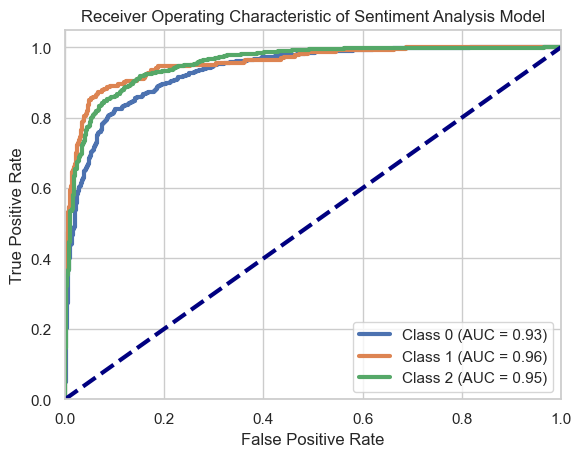

In [22]:
# Calculate ROC AUC scores for each class
roc_auc_scores = []
for class_idx in range(n_classes):
    roc_auc = roc_auc_score(Y_test[:, class_idx], y_probs[:, class_idx])
    roc_auc_scores.append(roc_auc)

# Plot ROC curves for each class
plt.figure()
for class_idx in range(n_classes):
    falsePositiveRate, truePositiveRate, _ = roc_curve(Y_test[:, class_idx], y_probs[:, class_idx])
    roc_auc = auc(falsePositiveRate, truePositiveRate)
    plt.plot(falsePositiveRate, truePositiveRate, lw=3, label=f'Class {class_idx} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Sentiment Analysis Model')
plt.legend(loc="lower right")
plt.show()

# *Confusion Matrix*
Confusion Matrix provide a nice overlook at the model's performance in classification task

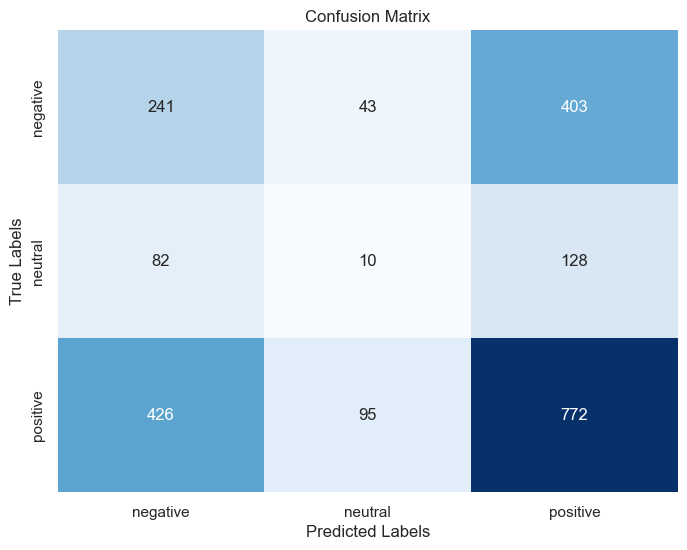

In [23]:
class_names = label_encoder.classes_

# Calculate confusion matrix
confusion = confusion_matrix(Y_test.argmax(axis=1), y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Model Testing

In [26]:
# Sample input text
input_text = """
Rasa syukur, cukup.
"""

# Define a function to clean and preprocess the input text
def clean_text(text):
    # Convert text to lowercase using the lower() function
    cleaned_text = text.lower()
    # Remove emoticons and punctuation using "RegEx" with the script below
    cleaned_text = re.sub(r'[^a-zA-Z0-9]', ' ', cleaned_text)
    return cleaned_text

# Define the possible sentiment labels
sentiment_labels = ['negative', 'neutral', 'positive']

# Clean and preprocess the input text
text = [clean_text(input_text)]

# Load the trained model
model_name = "LSTM"
model = load_model(model_name + '.h5')

# Tokenize and pad the input text for prediction
predicted = tokenizer.texts_to_sequences(text)
# X.shape[1] matches the model input length
guess = pad_sequences(predicted, maxlen=X.shape[1])  
# Make predictions using the loaded model
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

# Print the cleaned input text and the predicted sentiment label
print("Cleaned Text: ", text[0])
print("Predicted Sentiment: ", sentiment_labels[polarity])


1/1 [==============================] - 0s 263ms/step
Cleaned Text:   rasa syukur  cukup  
Predicted Sentiment:  positive
